# Tutorial Replication

The purpose of this notebook is simply to replicate Matt's tutorial, which can be found [on Panopto](https://ucdenver.hosted.panopto.com/Panopto/Pages/Sessions/List.aspx#folderID=%2265406b5e-52ef-428d-94d9-af6601597a08%22) in [two](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=c057cf3a-b1bd-4f85-a0e2-af66015ed850) [parts](https://ucdenver.hosted.panopto.com/Panopto/Pages/Viewer.aspx?id=b2e63522-720c-48e4-956a-af6901740c79). This will help us get an idea of how the syntax differs between pure ROOT and the Jupyter kernel implementation.

In [1]:
import uproot
import glob
import math
import numpy as np
import pandas as pd
import datetime as dt
import lmfit as lf
import matplotlib.pyplot as plt
#%matplotlib inline

(161790, 301)
['DetType', 'Empty', 'PAINTall', 'PAOFamps', 'PAOFamps0', 'PAOFchisq', 'PAOFchisqLF', 'PAOFdelay', 'PATFPamp', 'PATFPchisq', 'PATFPeflag', 'PATFPint', 'PATFPoffset', 'PATFPtau', 'PAWKf20', 'PAWKf40', 'PAWKf80', 'PAWKf90', 'PAWKf95', 'PAWKmax', 'PAWKr10', 'PAWKr100', 'PAWKr20', 'PAWKr30', 'PAWKr40', 'PAWKr50', 'PAWKr60', 'PAWKr70', 'PAWKr80', 'PAWKr90', 'PAWKr95', 'PAbias', 'PAbs', 'PAbspost', 'PAgain', 'PAnorm', 'PAsat', 'PAstd', 'PBINTall', 'PBOFamps', 'PBOFamps0', 'PBOFchisq', 'PBOFchisqLF', 'PBOFdelay', 'PBTFPamp', 'PBTFPchisq', 'PBTFPeflag', 'PBTFPint', 'PBTFPoffset', 'PBTFPtau', 'PBWKf20', 'PBWKf40', 'PBWKf80', 'PBWKf90', 'PBWKf95', 'PBWKmax', 'PBWKr10', 'PBWKr100', 'PBWKr20', 'PBWKr30', 'PBWKr40', 'PBWKr50', 'PBWKr60', 'PBWKr70', 'PBWKr80', 'PBWKr90', 'PBWKr95', 'PBbias', 'PBbs', 'PBbspost', 'PBgain', 'PBnorm', 'PBsat', 'PBstd', 'PCINTall', 'PCOFamps', 'PCOFamps0', 'PCOFchisq', 'PCOFchisqLF', 'PCOFdelay', 'PCTFPamp', 'PCTFPchisq', 'PCTFPeflag', 'PCTFPint', 'PCTFPoff

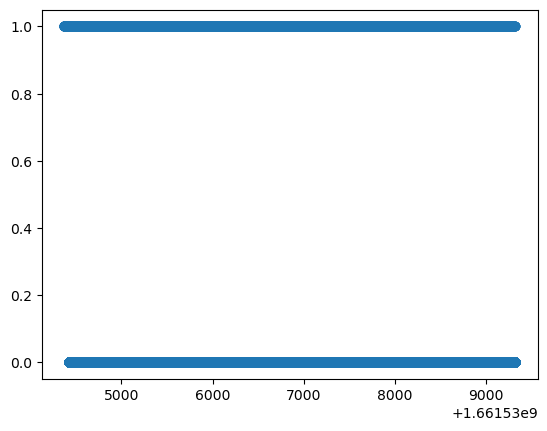

In [2]:
#These are for plotting, so we can ignore them for now
#gStyle->SetOptStat(0)
#gStyle->SetOptFit(1)
datapath ="R76Data/"
ser = ["07220822_1828","07220826_1219","07220826_1536","07220826_2007","07220827_1153","07220830_1724"]
lab = ["0V","-4V","-21V","-65V","-84V","-84V"]
#As a Chain is a collection of Trees, 
#I am approximating the chain as a list of Trees.
nser = 6; e = []; z = [];
for s in range(nser):
    e_chain = pd.DataFrame(); z_chain = pd.DataFrame();
    for file in glob.glob(datapath+ser[s]+"/umn*root"):
        if e_chain.empty: #For first entry, generate columns
            e_chain = pd.concat([e_chain,uproot.open(file)["rqDir/eventTree"].pandas.df()],axis=1)
            z_chain = pd.concat([z_chain,uproot.open(file)["rqDir/zip1"].pandas.df()],axis=1)
        else:
            e_chain = pd.concat([e_chain,uproot.open(file)["rqDir/eventTree"].pandas.df()],ignore_index=True)
            z_chain = pd.concat([z_chain,uproot.open(file)["rqDir/zip1"].pandas.df()],ignore_index=True)
    e.append(e_chain); z.append(z_chain)
    
#friends are complicated. here's the docs page on tchain friends: 
#https://root.cern/doc/master/classTChain.html#a967c9e4e14e314b46e4c11bc6a1c2353
#I think this is a reasonable approximation of them
for i,x in enumerate(z):
    z[i] = pd.concat([x,e[i]],axis=1)

print(z[0].shape)
print(list(z[0]))

plt.scatter(z[1]['EventTime'],z[1]['EventCategory'])
plt.show()

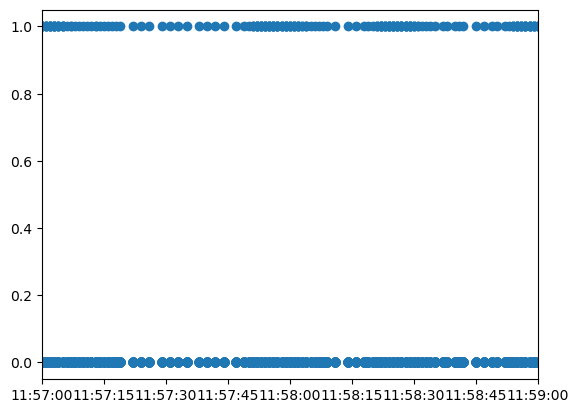

In [3]:
timestamps = [dt.datetime.fromtimestamp(x) for x in z[1]['EventTime'].values]
plt.scatter(timestamps,z[1]['EventCategory'])

#plt.xlim(dt.datetime(2020,8,26,11,56).timestamp(),dt.datetime(2020,8,26,12,00).timestamp())
#plt.xlim(pd.to_datetime("2020-08-26 11:56"),pd.to_datetime("2020-08-26 12:00"))

plt.xlim(pd.to_datetime("2022-08-26 11:57"),pd.to_datetime("2022-08-26 11:59"))
plt.show()

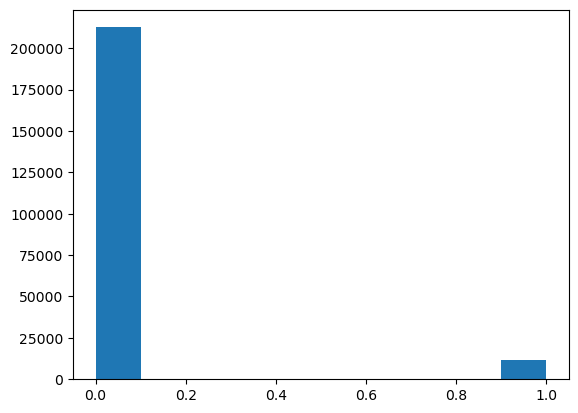

In [4]:
#I don't see a better way to handle the aliases than to simply add a pandas column.
#Unfortunately this means that we will have to rerun this cell if anything the aliases depends on changes.
for x in z:
    x['PTwid'] = (x['PTWKf40'] - x['PTWKr40'])*1e6
    x['xdel'] = 1e6*(x['PFWKr20'] - 0.5*(x['PCWKr20']+x['PDWKr20']))-1
    x['ydel'] = 1e6*(0.866*(x['PDWKr20'] - x['PCWKr20']))+9
    x['phidel'] = [180/np.pi*math.atan2(x['ydel'].array[j],x['xdel'].array[j]) for j in range(len(x['ydel'].array))]
    x['afdel'] = 1e6*(x['PFWKr20']-x['PAWKr20'])
    
plt.hist(z[1]['EventCategory'])
plt.show()

In [5]:
nentries = np.zeros(10); timestart = np.zeros(10); timeend = np.zeros(10);
crand = []; ctime0 = []; cam = []; cgoodwalk = []; notcrand = []
for i,x in enumerate(z):
    nentries[i] = x.shape[0]
    timestart[i] = e[i]['EventTime'].array[0]
    timeend[i] = e[i]['EventTime'].array[-1]
    crand.append(z[i]['EventCategory'])
    notcrand.append(z[i]['EventCategory']!=1)
    ctime0.append(z[i].index > 60000)
    cam.append(z[i]['PFOFamps']/z[i]['PTOFamps']>0.21)
    cgoodwalk.append((z[i]['PCWKr20'] > 0.25e-3)
                     & (z[i]['PCWKr20']<0.5e-3)
                     & (z[i]['PDWKr20']>0.25e-3)
                     & (z[i]['PDWKr20']<0.5e-3)
                     & (z[i]['PEWKr20']>0.25e-3)
                     & (z[i]['PEWKr20']<0.5e-3))
timesec = timeend - timestart

161790 33685


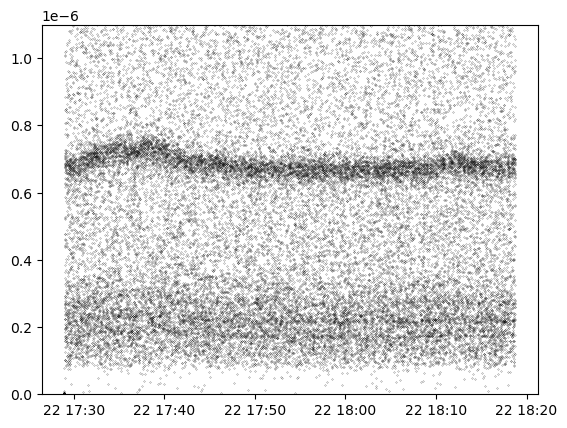

In [6]:
#print(len(notcrand[0]),len(cam[0]))
print(len(z[0]['PTOFamps']),len(z[0]['PTOFamps'][notcrand[0] & cam[0]]))
timestamps = [dt.datetime.fromtimestamp(x) for x in z[0]['EventTime'].values[notcrand[0] & cam[0]]]
plt.scatter(timestamps,z[0]['PTOFamps'][notcrand[0] & cam[0]],marker='.',s=0.1,color='k')

plt.ylim(0,1.1e-6)
plt.show()

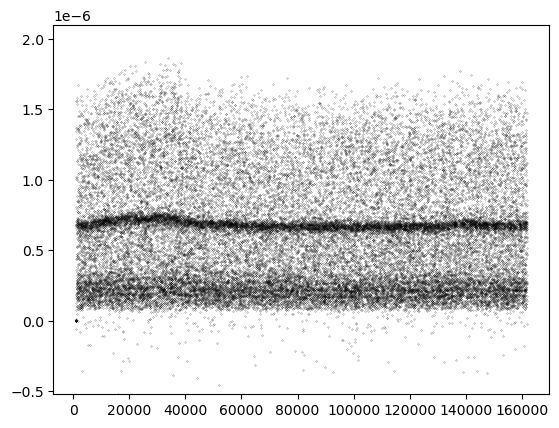

In [7]:
plt.scatter(z[0].index[notcrand[0] & cam[0]],z[0]['PTOFamps'][notcrand[0] & cam[0]],marker='.',s=0.1,color='k')

plt.ylim(-0.52e-6,2.1e-6)
#plt.xlim(0,180e3)
plt.show()

200
20


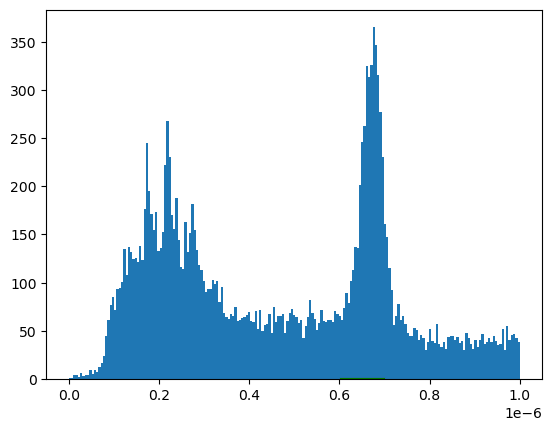

In [30]:
withcut = z[0]["PTOFamps"][notcrand[0] & cam[0] & ctime0[0]]
bins = np.linspace(0,1e-6,200)
hspec0 = plt.hist(withcut,bins=bins)
def gauss(x,A=1,mu=0,sigma=1):
    return A/(np.sqrt(2*np.pi)*sigma)*np.exp(-(x-mu)**2/(2*sigma**2))
subbins = bins[(bins >= 0.6e-6) & (bins <= 0.7e-6)]
print(len(hspec0[1]))
subdata = hspec0[0][(bins[:-1] >= 0.6e-6) & (bins[:-1] <= 0.7e-6)]
print(len(subdata))

mod = lf.Model(gauss)
params = mod.make_params(A=1,mu=0.675,sigma=1)
params.add('sigma',min=1e-10)
fit = mod.fit(subdata,params,weights=np.sqrt(subdata),x=subbins)

plt.plot(subbins,fit.best_fit) #garbage result...
plt.plot(subbins,fit.best_fit,color='blue')
plt.plot(subbins,gauss(subbins,A=1e3,mu=0.675,sigma=0.05),color='green')
#plt.plot(subbins,subdata)
plt.show()

fit

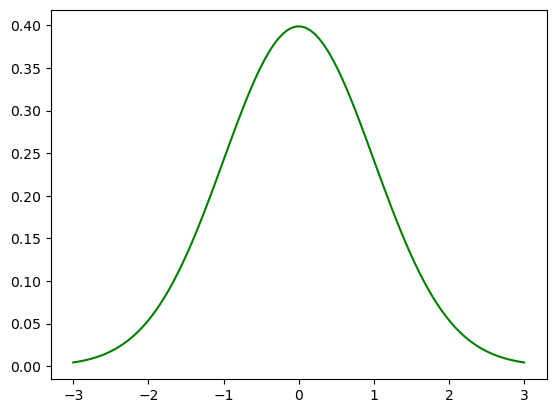

In [38]:
plt.plot(np.linspace(-3,3,100),gauss(np.linspace(-3,3,100)),color='green')
#plt.plot(bins,1e3/(np.sqrt(2*np.pi)*0.05))